**Molecular Dynamics simulation routine:**

this is some text that explains stuff you do.

* Import external libraries:

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import copy
import numpy as np
import scipy as scy

* Creating a particle class:

In [2]:
class Particle:
    def __init__(self, r, x, y, vx, vy):
        self.r = r
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy))

* Defining the box:

In [3]:
box_size_x = 20
box_size_y = 20

box = [box_size_x,box_size_y]

In [4]:
number_of_particles = 2

* Initialize velocities:

In [5]:
vel = np.ones(number_of_particles)*0.5
angles = np.random.uniform(0,2*np.pi,number_of_particles)


* Initialize position:

In [6]:
x_rand = np.random.randint(1,box[0]-1,number_of_particles)
y_rand = np.random.randint(1,box[1]-1,number_of_particles)


* Setting up the particle:

In [7]:
particles = []
for i in range(number_of_particles):
    particles.append(Particle(0.5,x_rand[i],y_rand[i],np.sin(angles[i])*vel[i],np.cos(angles[i])*vel[i]))


* Defining simulation step numbers

In [8]:
steps = 300

* initialize trajectory:

In [9]:
data_traj = np.zeros((number_of_particles,4,steps))
data_traj.shape

(2, 4, 300)

* define time integrator for numerical, stepwise solution of equation of motion with a discrete time step $dt$:

In [10]:
def move_unbound(p,dt):
    p.x = np.mod(p.x + p.vx*dt,box_size_x)
    p.y = np.mod(p.y + p.vy*dt,box_size_y)
    return p

* define box reflection:

In [28]:

def collide_boundary(particles,data_traj,step, dt):
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i < j:
                #print(i,j)
                distance_vector = np.array([particles[j].x-particles[i].x,particles[j].y-particles[i].y])# von i nach j
                distance = np.sqrt(np.abs(distance_vector[0])**2+np.abs(distance_vector[1])**2)
                if distance<(particles[i].r+particles[j].r):
                    print(step)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    # angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
                    '''
                    # calculate vectors that point to the last timestep
                    backward_i = np.array([data_traj[i][0][step-1]-particles[i].x,data_traj[i][1][step-1]-particles[i].y])
                    backward_j = np.array([data_traj[j][0][step-1]-particles[j].x,data_traj[j][1][step-1]-particles[j].y])

                    # angles between the those vectors and their connecting vector
                    alpha_i = np.pi/2-np.arccos(np.dot(distance_vector,backward_i))
                    alpha_j = np.pi/2-np.arccos(np.dot(-distance_vector,backward_j))

                    # length of how much back we must go
                    s = (particles[j].r+particles[j].r-distance)/(alpha_i+alpha_j)

                    # relative
                    delta_s = s/np.sqrt(np.abs(backward_i[0])**2+np.abs(backward_i[1])**2)
                    '''
                    # in time
                    #print(particles[i].vx-particles[j].vx)
                    diff_v = np.array([particles[i].vx-particles[j].vx,particles[i].vy-particles[j].vy])

                    diff_r = np.array([particles[i].x-particles[j].x,particles[i].y-particles[j].y])
                    
                    print(diff_v, diff_r)
                    sqrt = 2*np.sqrt(diff_v**2*diff_r**2-diff_v**2*(diff_r**2-4*(particles[i].r*particles[j].r)))
                    print(sqrt)
                    delta_t = -1*(-2*diff_v*diff_r + sqrt)/2*diff_v
                    
                    print(delta_t)
                    if delta_t[0] > 0:
                        print(True, delta_t)
                        delta_t = -1*(-2*diff_v*diff_r - sqrt)/2*diff_v

                    delta_t = np.mean(delta_t)

                    # rewind time to just outside of the collision
                    particles[i].x = np.mod(particles[i].x + particles[i].vx*delta_t,box_size_x)
                    particles[i].y = np.mod(particles[i].y + particles[i].vy*delta_t,box_size_y)
                    particles[j].x = np.mod(particles[j].x + particles[j].vx*delta_t,box_size_x)
                    particles[j].y = np.mod(particles[j].y + particles[j].vy*delta_t,box_size_y)

                    #debugging
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print('distance',distance)
                    print(particles[i],particles[j],'collided with a distance of ', distance)

                    #used chatGPT for debugging
                    # change the velocities

                    # only calculate once, used multiple times
                    sin_phi = np.sin(phi)
                    cos_phi = np.cos(phi)

                    # Get the velocities of particles i and j as variables
                    v1x, v1y = particles[i].vx, particles[i].vy
                    v2x, v2y = particles[j].vx, particles[j].vy

                    # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
                    new_v1x = (v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
                    new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
                    new_v2x = (v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
                    new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

                    # Update the particles' velocities
                    particles[i].vx, particles[i].vy = new_v1x, new_v1y
                    particles[j].vx, particles[j].vy = new_v2x, new_v2y
                    
                    # just for debugging
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print(particles[i],particles[j],'collided with a distance of ', distance)

                    # finish this time_step, that was rewound previously
                    particles[i].x = np.mod(particles[i].x + particles[i].vx*delta_t,box_size_x)
                    particles[i].y = np.mod(particles[i].y + particles[i].vy*delta_t,box_size_y)
                    particles[j].x = np.mod(particles[j].x + particles[j].vx*delta_t,box_size_x)
                    particles[j].y = np.mod(particles[j].y + particles[j].vy*delta_t,box_size_y)
                    # debugging
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    

In [29]:
a_1 = 1
a_2 = 0.5
beta_1 = np.pi*0.7
beta_2 = np.pi*0.7

h = (a_1-a_2)*1/(np.tan(beta_1)+np.tan(beta_2))
h

-0.1816356320013402

In [30]:
particles[0].x = 5
particles[0].y = 10
particles[0].vx = 0.2
particles[0].vy = 0.2

particles[1].x = 15
particles[1].y = 10
particles[1].vx = -0.2
particles[1].vy = 0.2

* carry out simulation:

In [31]:
dt = 1
for i in range(steps):
    for j in range(number_of_particles):
        #move(p1,1)
        #reflect(p1)
        move_unbound(particles[j],dt)
    collide_boundary(particles,data_traj,i,dt)
    for j in range(number_of_particles):
        data_traj[j,:,i] = [particles[j].x, particles[j].y, particles[j].vx, particles[j].vy]
        

22
This is a particle at 9.60, 14.60 with v=0.20,0.20 This is a particle at 10.40, 14.60 with v=-0.20,0.20 collided with a distance of  0.8000000000000203
[0.4 0. ] [-0.8  0. ]
[0.8 0. ]
[-0.288 -0.   ]
distance 0.857600000000021
This is a particle at 9.57, 14.57 with v=0.20,0.20 This is a particle at 10.43, 14.57 with v=-0.20,0.20 collided with a distance of  0.857600000000021
This is a particle at 9.57, 14.57 with v=-0.20,0.20 This is a particle at 10.43, 14.57 with v=0.20,0.20 collided with a distance of  0.857600000000021
This is a particle at 9.60, 14.54 with v=-0.20,0.20 This is a particle at 10.40, 14.54 with v=0.20,0.20 collided with a distance of  0.8000000000000203
70
This is a particle at 20.00, 4.14 with v=-0.20,0.20 This is a particle at 20.00, 4.14 with v=0.20,0.20 collided with a distance of  1.4210854715202004e-14
[-0.4  0. ] [1.42108547e-14 0.00000000e+00]
[0.8 0. ]
[ 0.16 -0.  ]
True [ 0.16 -0.  ]
distance 19.96799999999999
This is a particle at 0.02, 4.13 with v=-0.2

In [54]:
#data_traj

* Plotting trajectory with Matplotlib:

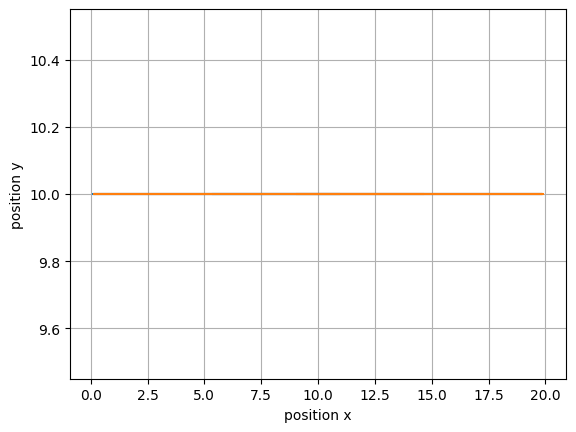

In [55]:
for data_traj_j in data_traj:
    plt.plot(data_traj_j[0],data_traj_j[1],'-')
plt.xlabel('position x')
plt.ylabel('position y')

plt.grid()
plt.show()

**Animate trajectory:**

* Set up the figure, the axis, and the plot element we want to animate

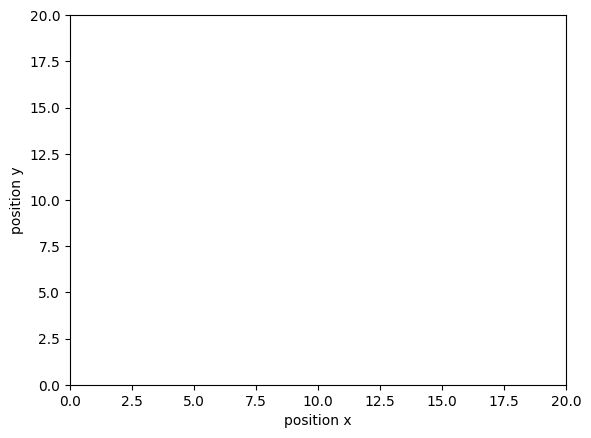

In [20]:
fig, ax = plt.subplots()

ax.set_xlim((0, box[0]))
ax.set_ylim((0, box[1]))

plt.xlabel('position x')
plt.ylabel('position y')

dot, = ax.plot([], [], 'bo', ms=5.0)


* initialization function: plot the background of each frame

In [21]:
def init():
    dot.set_data([], [])
    return (dot,)

In [22]:
data_traj[:,0,1]

array([ 4.99954653, 14.52138435, 14.66638213, 18.41294024, 13.73559595,
       15.36866218,  9.43465244, 13.86312627, 16.27396717,  3.6413942 ,
        0.8385576 , 14.37744977,  3.39906066,  8.3981713 ,  3.80487981,
        2.85509918,  7.76334133,  6.01056399, 13.97165882, 16.69457739,
       12.67381612,  1.83676742, 13.39294059,  6.15386112, 11.93274048,
       10.68438744,  3.26640023,  3.02516389, 17.31068537, 15.64488101,
       16.94733457, 16.99941267,  9.82836805, 17.0272489 ,  1.47433283,
       14.16132462, 17.00946043, 13.73151779,  1.72288402,  8.42493023,
        5.30149447, 12.59816567,  5.89876339,  4.68203281, 12.13935532,
       11.02252431,  0.39297395,  2.81456885, 19.93407523,  2.19618283])

* animation function. This is called sequentially

In [23]:
def animate(i):
    x = data_traj[:,0,i]
    y = data_traj[:,1,i]
    dot.set_data(x, y)
    return (dot,)

* call the animator. blit=True means only re-draw the parts that have changed.

In [24]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=60, blit=True)

In [25]:
HTML(anim.to_html5_video())

**Histogramming:**

KeyboardInterrupt: 

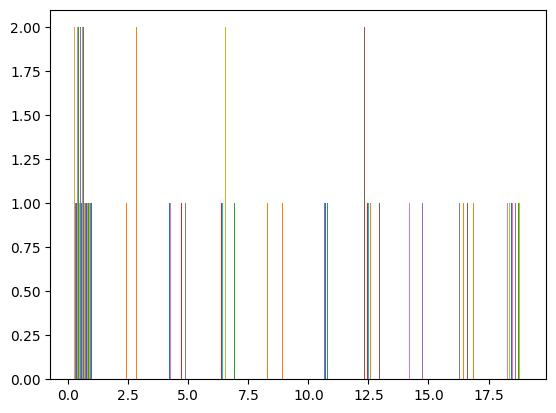

In [173]:
plt.hist(data_traj[0],range=(0,box[0]),bins=10)
plt.xlabel('position x')
plt.ylabel('occupancy')
plt.show()

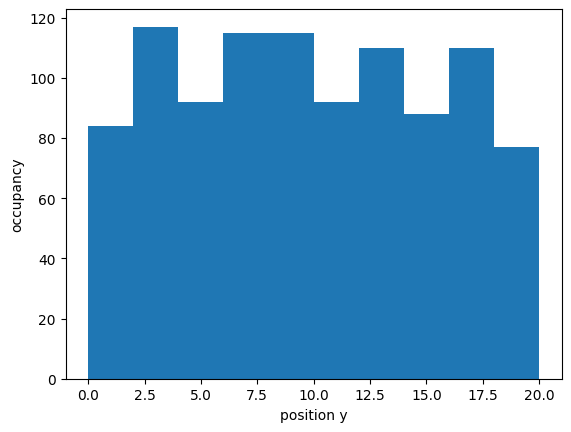

In [22]:
plt.hist(data_traj[1],range=(0,box[1]),bins=10)
plt.xlabel('position y')
plt.ylabel('occupancy')
plt.show()

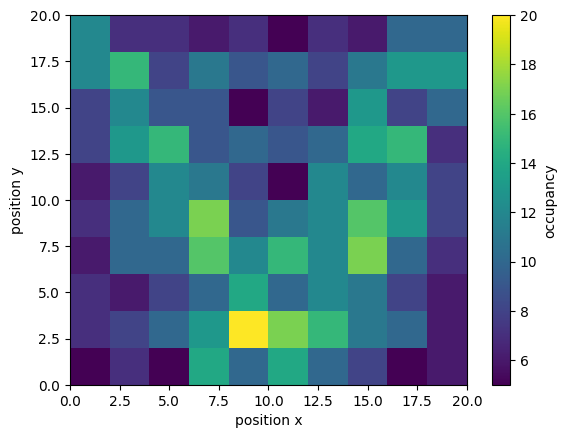

In [23]:
plt.hist2d(data_traj[0], data_traj[1], range=[[0,box[0]],[0,box[1]]], bins=10)
plt.xlabel('position x')
plt.ylabel('position y')
plt.colorbar().set_label('occupancy')
plt.show()

**Interpretation:**
* in the reduced data projection, the occupancy of each bin seems even and well-distributed
* in the full dimensional projection, it can be seen easily that the box is **not** fully sampled, large undersampled patches present
* *data dimensionality reduction always brings the danger of wrong projection!*

**Solution for improvements:**
* enhance sampling by
    * prolong the simulation
    * increase the time step
* *Caveat: all solutions come with problems like increased computational cost or sampling errors!*